In [1]:
import torch
from torch.utils.data import DataLoader
import tqdm
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
import os
import math
from models import utils
# from datasets import coco
from configuration import Config
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torchvision as tv
from PIL import Image
import random
from transformers import BertTokenizer
from datasets.utils import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import warnings
warnings.filterwarnings("ignore") 
torch.cuda.empty_cache()
# from engine import train_one_epoch, evaluate

# Dataset

In [2]:
MAX_DIM = 299

def under_max(image):
    if image.mode != 'RGB':
        image = image.convert("RGB")

    shape = np.array(image.size, dtype=np.float)
    long_dim = max(shape)
    scale = MAX_DIM / long_dim

    new_shape = (shape * scale).astype(int)
    image = image.resize(new_shape)

    return image


class RandomRotation:
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle, expand=True)


train_transform = tv.transforms.Compose([
    RandomRotation(),
    tv.transforms.Lambda(under_max),
    tv.transforms.ColorJitter(brightness=[0.5, 1.3], contrast=[
                              0.8, 1.5], saturation=[0.2, 1.5]),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

val_transform = tv.transforms.Compose([
    tv.transforms.Lambda(under_max),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


class CocoCaption(Dataset):
    def __init__(self, root, ann, max_length, limit, transform=train_transform, mode='training'):
        super().__init__()

        self.root = root
        self.transform = transform
        self.annot = [(val['image_id'], val['caption'])
                      for val in ann['annotations']]
        if mode == 'validation':
            self.annot = self.annot
        if mode == 'training':
            self.annot = self.annot[: limit]

        self.tokenizer = BertTokenizer.from_pretrained(
            'bert-base-uncased', do_lower=True)
        self.max_length = max_length + 1

    def _process(self, image_id):
        val = str(image_id).zfill(12)
        return val + '.jpg'

    def __len__(self):
        return len(self.annot)

    def __getitem__(self, idx):
        image_id, caption = self.annot[idx]
        image = Image.open(self.root + '/' +image_id)
        if self.transform:
            image = self.transform(image)
        image = nested_tensor_from_tensor_list_data(image.unsqueeze(0))

        caption_encoded = self.tokenizer.encode_plus(
            caption, max_length=self.max_length, pad_to_max_length=True, return_attention_mask=True, return_token_type_ids=False, truncation=True)

        caption = np.array(caption_encoded['input_ids'])
        cap_mask = (
            1 - np.array(caption_encoded['attention_mask'])).astype(bool)

        return image.tensors.squeeze(0), image.mask.squeeze(0), caption, cap_mask


def build_dataset(config, mode='training'):
    if mode == 'training':
        train_dir = config.dir+'/train'
        train_file = config.dir+'/annotations_train.json'
        data = CocoCaption(train_dir, read_json(
            train_file), max_length=config.max_position_embeddings, limit=config.limit, transform=train_transform, mode='training')
        return data

    elif mode == 'validation':
        val_dir = config.dir+'/valid'
        val_file = config.dir+'/annotations_valid.json'
        data = CocoCaption(val_dir, read_json(
            val_file), max_length=config.max_position_embeddings, limit=config.limit, transform=val_transform, mode='validation')
        return data

    else:
        raise NotImplementedError(f"{mode} not supported")

# Engine

In [3]:
from models import utils
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
def train_one_epoch(model, criterion, data_loader,
                    optimizer, device, epoch, max_norm):
    model.train()
    criterion.train()

    epoch_loss = 0.0
    total = len(data_loader)

    with tqdm.tqdm(total=total) as pbar:
        for images, masks, caps, cap_masks in data_loader:
            samples = utils.NestedTensor(images, masks).to(device)
            caps = caps.to(device)
            cap_masks = cap_masks.to(device)
            outputs = model(samples, caps[:, :-1], cap_masks[:, :-1])
            loss = criterion(outputs.permute(0, 2, 1), caps[:, 1:].type(torch.LongTensor).to(device))
            loss_value = loss.item()
            epoch_loss += loss_value

            if not math.isfinite(loss_value):
                print(f'Loss is {loss_value}, stopping training')
                sys.exit(1)

            optimizer.zero_grad()
            loss.backward()
            if max_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()
            pbar.update(1)

    return epoch_loss / total

@torch.no_grad()
def evaluate(model, criterion, data_loader, device):
    model.eval()
    criterion.eval()

    validation_loss = 0.0
    total = len(data_loader)

    with tqdm.tqdm(total=total) as pbar:
        for images, masks, caps, cap_masks in data_loader:
            samples = utils.NestedTensor(images, masks).to(device)
            caps = caps.to(device)
            cap_masks = cap_masks.to(device)

            outputs = model(samples, caps[:, :-1], cap_masks[:, :-1])
            loss = criterion(outputs.permute(0, 2, 1), caps[:, 1:].type(torch.LongTensor).to(device))

            validation_loss += loss.item()

            pbar.update(1)
        
    return validation_loss / total

# Backbone Model

In [4]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
from collections import OrderedDict

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torchvision.models._utils import IntermediateLayerGetter
#https://blog.csdn.net/qq_35037684/article/details/118975018
from typing import Dict, List

from models.utils import NestedTensor, is_main_process

from models.position_encoding import build_position_encoding


class FrozenBatchNorm2d(torch.nn.Module):
    """
    BatchNorm2d where the batch statistics and the affine parameters are fixed.
    Copy-paste from torchvision.misc.ops with added eps before rqsrt,
    without which any other models than torchvision.models.resnet[18,34,50,101]
    produce nans.
    """

    def __init__(self, n):
        super(FrozenBatchNorm2d, self).__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))

    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        num_batches_tracked_key = prefix + 'num_batches_tracked'
        if num_batches_tracked_key in state_dict:
            del state_dict[num_batches_tracked_key]

        super(FrozenBatchNorm2d, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys, error_msgs)

    def forward(self, x):
        # move reshapes to the beginning
        # to make it fuser-friendly
        w = self.weight.reshape(1, -1, 1, 1)
        b = self.bias.reshape(1, -1, 1, 1)
        rv = self.running_var.reshape(1, -1, 1, 1)
        rm = self.running_mean.reshape(1, -1, 1, 1)
        eps = 1e-5
        scale = w * (rv + eps).rsqrt()
        bias = b - rm * scale
        return x * scale + bias


class BackboneBase(nn.Module):
    def __init__(self, backbone: nn.Module, train_backbone: bool, num_channels: int, return_interm_layers: bool):
        super().__init__()
        for name, parameter in backbone.named_parameters():
            if not train_backbone or 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
                parameter.requires_grad_(False)
        if return_interm_layers:
            return_layers = {"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"}
        else:
            return_layers = {'layer4': "0"}
        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.num_channels = num_channels

    def forward(self, tensor_list: NestedTensor):
        xs = self.body(tensor_list.tensors)
        out: Dict[str, NestedTensor] = {}
        for name, x in xs.items():
            #x.shape = (B, 2048, 19, 19)
            m = tensor_list.mask
            assert m is not None
            mask = F.interpolate(m[None].float(), size=x.shape[-2:]).to(torch.bool)[0]
            #mask.shape = 19, 19
            out[name] = NestedTensor(x, mask)
        return out


class Backbone(BackboneBase):
    """ResNet backbone with frozen BatchNorm."""
    def __init__(self, name: str,
                 train_backbone: bool,
                 return_interm_layers: bool,
                 dilation: bool):
        backbone = getattr(torchvision.models, name)(
            replace_stride_with_dilation=[False, False, dilation],
            pretrained=is_main_process(), norm_layer=FrozenBatchNorm2d)
        num_channels = 512 if name in ('resnet18', 'resnet34') else 2048
        super().__init__(backbone, train_backbone, num_channels, return_interm_layers)


class Joiner(nn.Sequential):
    def __init__(self, backbone, position_embedding):
        super().__init__(backbone, position_embedding)

    def forward(self, tensor_list: NestedTensor):
        xs = self[0](tensor_list)
        out: List[NestedTensor] = []
        pos = []
        for name, x in xs.items():
            out.append(x)
            # position encoding
            pos.append(self[1](x).to(x.tensors.dtype))
        #pos.shape = list with one element of (B, 256, 19, 19)
        return out, pos


def build_backbone(config):
    position_embedding = build_position_encoding(config)
    train_backbone = config.lr_backbone > 0
    return_interm_layers = False
    backbone = Backbone(config.backbone, train_backbone, return_interm_layers, config.dilation)
    model = Joiner(backbone, position_embedding)
    model.num_channels = backbone.num_channels
    return model

# Build Model

In [5]:
import torch
from torch import nn
import torch.nn.functional as F

from models.utils import NestedTensor, nested_tensor_from_tensor_list
from models.transformer import build_transformer


class Caption(nn.Module):
    def __init__(self, backbone, transformer, hidden_dim, vocab_size):
        super().__init__()
        self.backbone = backbone
        self.input_proj = nn.Conv2d(
            backbone.num_channels, hidden_dim, kernel_size=1)
        self.transformer = transformer
        self.mlp = MLP(hidden_dim, 512, vocab_size, 3)

    def forward(self, samples, target, target_mask):
        if not isinstance(samples, NestedTensor):
            samples = nested_tensor_from_tensor_list(samples)

        features, pos = self.backbone(samples)
        src, mask = features[-1].decompose()
        assert mask is not None

        hs = self.transformer(self.input_proj(src), mask,
                              pos[-1], target, target_mask)
        out = self.mlp(hs.permute(1, 0, 2))
        return out


class MLP(nn.Module):
    """ Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k)
                                    for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x


def build_model(config):
    backbone = build_backbone(config)
    transformer = build_transformer(config)

    model = Caption(backbone, transformer, config.hidden_dim, config.vocab_size)
    criterion = torch.nn.CrossEntropyLoss()

    return model, criterion

Initializing Device: cuda
Number of trainable params: 83959866
Train: 3919
Valid: 560
Start Training 30 epochs
Epoch: 0


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [03:23<00:00,  1.20it/s]


Training Loss: 0.14143542320940827
Start doing validation


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.56it/s]


Validation Loss: 0.08043829011065619
Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [02:36<00:00,  1.55it/s]


Training Loss: 0.06999006884203093
Start doing validation


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.69it/s]


Validation Loss: 0.05875542147883347
saving checkpoints
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [02:33<00:00,  1.59it/s]


Training Loss: 0.05134291403362008
Start doing validation


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.69it/s]


Validation Loss: 0.04925794542900153
saving checkpoints
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [02:38<00:00,  1.54it/s]


Training Loss: 0.04016103405413813
Start doing validation


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.72it/s]


Validation Loss: 0.04451986396951335
saving checkpoints
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [02:32<00:00,  1.60it/s]


Training Loss: 0.03220635587654886
Start doing validation


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.67it/s]


Validation Loss: 0.040403916527118
saving checkpoints
Epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [02:30<00:00,  1.62it/s]


Training Loss: 0.027518905989337164
Start doing validation


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.76it/s]


Validation Loss: 0.039834206817405564
saving checkpoints
Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [04:49<00:00,  1.19s/it]


Training Loss: 0.024575311194372472
Start doing validation


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:15<00:00,  2.21it/s]


Validation Loss: 0.03886755060936723
saving checkpoints
Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [02:33<00:00,  1.59it/s]


Training Loss: 0.022448545550835915
Start doing validation


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.68it/s]


Validation Loss: 0.038808229618838855
saving checkpoints
Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [02:29<00:00,  1.63it/s]


Training Loss: 0.02065611293646278
Start doing validation


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.75it/s]


Validation Loss: 0.038356110666479384
saving checkpoints
Epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [02:41<00:00,  1.51it/s]


Training Loss: 0.019814117074959347
Start doing validation


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.76it/s]


Validation Loss: 0.0380164232637201
saving checkpoints
Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [02:45<00:00,  1.47it/s]


Training Loss: 0.018576775181305703
Start doing validation


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.72it/s]


Validation Loss: 0.038493470368640766
Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [02:40<00:00,  1.52it/s]


Training Loss: 0.017784147782892477
Start doing validation


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:10<00:00,  3.19it/s]


Validation Loss: 0.03855909715805735


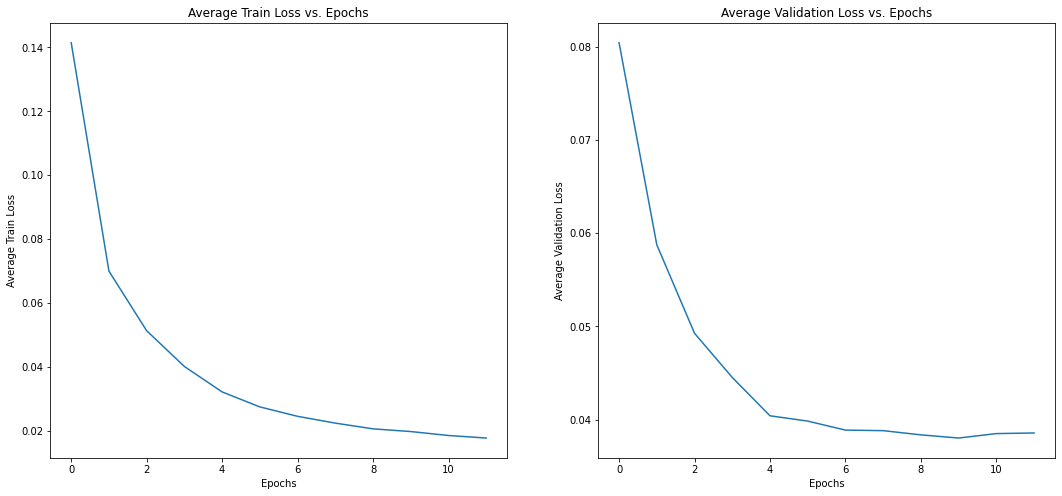

In [6]:
def main(config):
    print(f'Initializing Device: {device}')

    seed = config.seed + utils.get_rank()
    torch.manual_seed(seed)
    np.random.seed(seed)

    model, criterion = build_model(config)
    model.load_state_dict(torch.load('./saved_checkpoints/pretrained_model.pt'))
    model.to(device)
    n_parameters = sum(p.numel()
                       for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable params: {n_parameters}")

    param_dicts = [
        {"params": [p for n, p in model.named_parameters(
        ) if "backbone" not in n and p.requires_grad]},
        {
            "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": config.lr_backbone,
        },
    ]
    optimizer = torch.optim.AdamW(
        param_dicts, lr=config.lr, weight_decay=config.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, config.lr_drop)

    dataset_train = build_dataset(config, mode='training')
    dataset_val = build_dataset(config, mode='validation')
    print(f"Train: {len(dataset_train)}")
    print(f"Valid: {len(dataset_val)}")

    sampler_train = torch.utils.data.RandomSampler(dataset_train)
    sampler_val = torch.utils.data.SequentialSampler(dataset_val)

    batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, config.batch_size, drop_last=True
    )

    data_loader_train = DataLoader(
        dataset_train, batch_sampler=batch_sampler_train)
    data_loader_val = DataLoader(dataset_val, config.batch_size,
                                 sampler=sampler_val, drop_last=False)    
    
    if os.path.exists(config.checkpoint):
        print("Loading Checkpoint...")
        checkpoint = torch.load(config.checkpoint, map_location='cpu')
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        config.start_epoch = checkpoint['epoch'] + 1

    train_loss_set = []
    valid_loss_set = []
    print("Start Training {} epochs".format(config.epochs))
    for epoch in range(config.start_epoch, config.epochs):
        print(f"Epoch: {epoch}")
        model.train()
        epoch_loss = train_one_epoch(
            model, criterion, data_loader_train, optimizer, device, epoch, config.clip_max_norm)
        train_loss_set.append(epoch_loss)
        lr_scheduler.step()
        print(f"Training Loss: {epoch_loss}")
        
        print('Start doing validation')
        model.eval()
        validation_loss = evaluate(model, criterion, data_loader_val, device)
        print(f"Validation Loss: {validation_loss}")
        #save the checkpoint if the current validation loss is better than all previous epochs   
        if len(valid_loss_set) > 0 and validation_loss < min(valid_loss_set):
            torch.save(model.state_dict(), './saved_checkpoints/best_CPTR.pt')
            print('saving checkpoints')
        #stop training if the validation loss increases for two consecutive epochs     
        if len(valid_loss_set) > 2 and validation_loss > valid_loss_set[-1] and valid_loss_set[-1] > valid_loss_set[-2]:
            valid_loss_set.append(validation_loss)  
            break           
        else:
            valid_loss_set.append(validation_loss)
                
    return train_loss_set, valid_loss_set, epoch


config = Config()
train_loss_set, valid_loss_set, epoch = main(config)
#plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
epoch_values = list(range(0, epoch+1, 1))

ax1.plot(epoch_values, train_loss_set)
ax2.plot(epoch_values, valid_loss_set)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Average Train Loss')    
ax1.set_title('Average Train Loss vs. Epochs')

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Average Validation Loss')    
ax2.set_title('Average Validation Loss vs. Epochs')
plt.show()  